In [34]:
import functools
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.stats as sct
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_blobs, make_classification
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn import preprocessing as prpc


In [2]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Predict
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, #clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)


In [3]:
df = pd.read_csv('train.csv', index_col='NU_INSCRICAO')
test2 = test = pd.read_csv('test.csv', index_col='NU_INSCRICAO')

cols = list(test.columns)+['IN_TREINEIRO']
df = df[list(cols)]

test

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,,,
ba0cc30ba34e7a46764c09dfc38ed83d15828897,43,RS,19,F,1,1,1,3,1,NaN,...,NaN,NaN,E,E,H,B,B,C,D,A
177f281c68fa032aedbd842a745da68490926cd2,15,PA,24,M,3,2,1,4,1,NaN,...,NaN,NaN,B,C,B,A,A,C,D,A
6cf0d8b97597d7625cdedc7bdb6c0f052286c334,29,BA,16,F,2,1,3,0,1,NaN,...,NaN,NaN,E,F,G,B,B,A,NaN,D
5c356d810fa57671402502cd0933e5601a2ebf1e,41,PR,17,F,1,1,2,0,2,1.0,...,40.0,480.0,E,E,E,C,B,B,C,A
df47c07bd881c2db3f38c6048bf77c132ad0ceb3,53,DF,19,F,1,1,1,1,1,NaN,...,80.0,720.0,E,E,E,B,B,B,D,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361b7fcd8867119550fe2af5aa729ffad89a7cf5,31,MG,17,F,2,1,2,0,3,1.0,...,120.0,620.0,B,E,D,B,B,A,NaN,D
d8a0e4c9e29494cc9bba2422bd79333931475ee1,35,SP,20,F,1,1,1,2,1,NaN,...,20.0,320.0,A,B,B,A,A,C,NaN,B
3f1c3388244df8d6521e983a809292d9f3bca643,11,RO,22,F,3,1,1,5,1,NaN,...,60.0,500.0,D,E,E,B,A,B,E,A


In [4]:
def dropC(DF, percMissing):
    
    dfrt = DF.drop(columns = DF.columns[list((DF.isnull().sum()/DF.shape[0])>percMissing)])

    return dfrt


In [5]:
trainV1 = dropC(df, 0.25)

In [6]:

trainV1['NU_NOTA_CN'] = trainV1['NU_NOTA_CN'].fillna(trainV1['NU_NOTA_CN'].mean(skipna=True).item())
trainV1['NU_NOTA_CH'] = trainV1['NU_NOTA_CH'].fillna(trainV1['NU_NOTA_CH'].mean(skipna=True).item())


In [7]:
testV1 = dropC(test, 0.25)

In [8]:

testV1['NU_NOTA_CN'] = testV1['NU_NOTA_CN'].fillna(testV1['NU_NOTA_CN'].mean(skipna=True).item())
testV1['NU_NOTA_CH'] = testV1['NU_NOTA_CH'].fillna(testV1['NU_NOTA_CH'].mean(skipna=True).item())


In [9]:
np.abs(trainV1.corr()['IN_TREINEIRO']).sort_values(ascending=False)[1:]

TP_ST_CONCLUSAO     0.533983
NU_IDADE            0.295091
TP_ANO_CONCLUIU     0.257710
TP_ESCOLA           0.244562
TP_PRESENCA_CH      0.094692
TP_PRESENCA_CN      0.094692
TP_PRESENCA_MT      0.092454
TP_PRESENCA_LC      0.092454
NU_NOTA_CH          0.049031
TP_LINGUA           0.036395
CO_UF_RESIDENCIA    0.034944
NU_NOTA_CN          0.034736
TP_NACIONALIDADE    0.015179
IN_BAIXA_VISAO      0.013602
IN_GESTANTE         0.011893
TP_COR_RACA         0.009676
IN_SURDEZ           0.007374
IN_IDOSO            0.004663
IN_SABATISTA        0.003824
IN_DISCALCULIA      0.003297
IN_DISLEXIA         0.003297
IN_CEGUEIRA              NaN
Name: IN_TREINEIRO, dtype: float64

In [10]:
#trainV1.drop(columns = trainV1.columns[list(trainV1.corr()['IN_TREINEIRO']<0.02)], inplace=True)
#trainV1.columns[list(trainV1.corr()['IN_TREINEIRO']<0.02)]
trainV1.columns

Index(['CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO',
       'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU',
       'TP_ESCOLA', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ',
       'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_SABATISTA', 'IN_GESTANTE',
       'IN_IDOSO', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC',
       'TP_PRESENCA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'TP_LINGUA', 'Q001',
       'Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q047', 'IN_TREINEIRO'],
      dtype='object')

In [11]:
trainV1.corr()['IN_TREINEIRO']


CO_UF_RESIDENCIA   -0.034944
NU_IDADE           -0.295091
TP_COR_RACA         0.009676
TP_NACIONALIDADE   -0.015179
TP_ST_CONCLUSAO     0.533983
TP_ANO_CONCLUIU    -0.257710
TP_ESCOLA          -0.244562
IN_BAIXA_VISAO     -0.013602
IN_CEGUEIRA              NaN
IN_SURDEZ          -0.007374
IN_DISLEXIA        -0.003297
IN_DISCALCULIA     -0.003297
IN_SABATISTA        0.003824
IN_GESTANTE        -0.011893
IN_IDOSO           -0.004663
TP_PRESENCA_CN      0.094692
TP_PRESENCA_CH      0.094692
TP_PRESENCA_LC      0.092454
TP_PRESENCA_MT      0.092454
NU_NOTA_CN         -0.034736
NU_NOTA_CH         -0.049031
TP_LINGUA          -0.036395
IN_TREINEIRO        1.000000
Name: IN_TREINEIRO, dtype: float64

,CO_UF_RESIDENCIA,NU_IDADE,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,...,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,NU_NOTA_CN,NU_NOTA_CH,TP_LINGUA
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,,,
ba0cc30ba34e7a46764c09dfc38ed83d15828897,43,19,1,1,1,3,1,0,0,0,...,0,0,0,1,1,0,0,495.300000,593.300000,1
177f281c68fa032aedbd842a745da68490926cd2,15,24,3,2,1,4,1,0,0,0,...,0,0,0,0,0,0,0,473.925651,528.615818,1
6cf0d8b97597d7625cdedc7bdb6c0f052286c334,29,16,2,1,3,0,1,0,0,0,...,0,0,0,1,1,0,0,559.100000,529.300000,0
5c356d810fa57671402502cd0933e5601a2ebf1e,41,17,1,1,2,0,2,0,0,0,...,0,0,0,1,1,1,1,475.000000,557.800000,1
df47c07bd881c2db3f38c6048bf77c132ad0ceb3,53,19,1,1,1,1,1,0,0,0,...,0,0,0,1,1,1,1,440.500000,596.100000,1


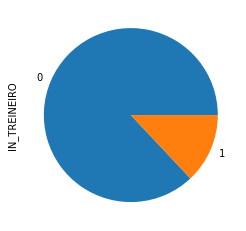

In [36]:
trainDF = trainV1.select_dtypes(exclude=['object'])
testDF = testV1.select_dtypes(exclude=['object'])

target = 'IN_TREINEIRO'

features = list(testDF.columns)

trainDF['IN_TREINEIRO'].value_counts().plot(kind='pie')


In [61]:
#balancear

X_un = trainDF[features]
y_un = trainDF[target]

smote = SMOTE()
X, y = smote.fit_resample(X_un, y_un)

Xsld = X #prpc.scale(X)
testSld = testDF #prpc.scale(testDF)

#logsModel = LogisticRegression(random_state=0, solver='liblinear')
#logsModel.fit(Xsld, y)
#ypred = logsModel.predict(testSld)

rfc = RandomForestClassifier(random_state=0, n_estimators=919)
rfc.fit(Xsld, y)

yPred = rfc.predict(testSld)

answer = pd.DataFrame(data={'IN_TREINEIRO': yPred}, index=testDF.index)


In [60]:
answer.describe()

,IN_TREINEIRO
count,4570.000000
mean,0.124508
std,0.330196
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [62]:
answer.to_csv('answer.csv')